**Overview:**


My project will utilize the OpenAI Gym package to attempt to build a reinforcement-learning (RL) agent that can learn to play the Lunar Lander game competently. Lunar Lander is a classic game that requires the agent to safely land a vehicle as it falls to the surface of the moon. The vehicle is affected by gravity and has the ability to do nothing or use a left, right, or central thruster to push itself in the opposite direction. I will compare the performance of the RL agent to the baseline of a random agent.


The environment provides a state snapshot consisting of the x and y coordinates of the lander, the x and y velocities of the lander, the angle and angular momentum of the lander, and the Boolean status of whether each of the lander’s feet are touching the ground. The RL agent can be tested against either a discrete or continuous environment—I will be using the discrete environment for simplicity’s sake.


Rewards are subtracted for using engines, crashing, and moving further from the landing pad. Rewards are given for landing successfully and landing successfully on the landing pad.

**Approach and Results:**

I have selected a Deep Q-Learning approach to this project, which is a Q-Learning algorithm that uses a neural network to assess q values and select actions instead of a q value table. A traditional q-learning algorithm would not be a prudent choice in this case as the complexity of the state would make for an extremely large q value table; it could be effective, but would take a very long time to train. I do think I could potentially craft an algorithm that would sort the possible states into buckets that would reduce the complexity sufficiently for a traditional algorithm, but that will have to await further work after the conclusion of this project.


The primary feature of my approach is the neural network. Using tensorflow and Google Colab, I created a neural network featuring the following layers:



|Layer|Perceptrons|Activation|
| --- | --- | --- |
|Input|32|ReLu|
|Hidden|16|ReLu|
|Output|4|Linear|

Loss Function: Huber

Optimization: Adam

ReLu and Linear activations were chosen for their efficiency and their ability to support outputs larger than 1.0. Since the output is a Q Value tied to rewards that are up to 200, it is both more efficient and appropriate to use these type of activations. With 4 outputs, a softmax could work, but would require additional computation for little benefit. I used the huber loss function since it is less sensitive to outliers than squared error.


I began with this arrangement of perceptrons based on it being a multiple of the 8 inputs in the environment observation state. I experimented with layers up to 64 and as low as 8. The 32/16 arrangement proved to be the most effective.


The neural networks in deep q learning are twinned. There is a model which is fed new observations (consisting of the old state, action taken, reward, and new state) frequently. In my case, every four training steps (i.e., actions taken) triggers a new training sequence.


Another model, architecturally identical to the first and known as the target model, is updated only once every 100 training steps. This is to smooth out the small effects of any given batch.

The training sequence is as follows:
1.	Take four actions.
a.	Based on a decaying epsilon, some of these actions are random, others are policy-based.
2.	Using a batch size of 256 observations, pulled from all previous observations (up to a maximum of 50,000), predict new q values for the current state (using the frequent model) and future state (using the target model).
3.	Perform a bellman update, combining the two values based on a non-decaying learning rate of 0.7.
4.	Using the old states and the updated q-values, refit the frequent model.
5.	Every 100 actions or the current episode is complete, whichever comes second, update the target model with the frequent model’s weights.

I repeated this for 1,000 training episodes. This graph shows the reward over training episodes. The training run took several hours using GPU-boosted Google Colab.



In [ ]:
#This was taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT
#Was struggling to set up the gym environment beforehand

# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
#Upgrade gym to latest version for better video recording
!pip uninstall gym
!pip install gym
!pip install gym[box2d]
!pip show gym

In [ ]:
#set up initial dependencies and display method show_video from aforementioned colab notebook
import gym
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import random
import numpy as np
from collections import deque

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

display = Display(visible=0, size=(1400, 900))
display.start()

#The below method taken from https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT
# with a modification to be able to call a specific video by index"

def show_video(folder, video_id):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[video_id]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [4]:
#Demonstration of the observation and action space

env = gym.make("LunarLander-v2", new_step_api = True)

obs = env.reset()
print("First obs", obs)
action = env.action_space.sample()
obs, reward, done, info, _ = env.step(action)
print("Second obs", obs)
print("reward", reward)
print("Done", done)


print("Action Space: ", env.action_space)
print("State Space: ", env.observation_space.shape)


First obs [ 0.00475636  1.4105724   0.4817523  -0.01545404 -0.00550465 -0.10912408
  0.          0.        ]
Second obs [ 0.00951281  1.4096477   0.48110119 -0.04112822 -0.01089694 -0.10785519
  0.          0.        ]
reward -0.534753068666248
Done False
Action Space:  Discrete(4)
State Space:  (8,)


In [ ]:
#Set up universal parameters

SEED = 42
tf.random.set_seed(SEED)

env = gym.make("LunarLander-v2")
env = gym.wrappers.RecordVideo(env, 'video4', episode_trigger = lambda x: x % 100 == 0)
env.seed(SEED)
np.random.seed(SEED)


#Was designed for 2000 episodes. This was however, too time intensive so I was forced to cut it short.
train_episodes = 2000

In [112]:
#set up neural network according to shape of observation and action spaces
#the output layer will predict a q-value for each action
#Action reference: [do nothing, left engine, main engine, right engine]
def agent(state_shape, action_shape):

  init = tf.keras.initializers.HeUniform()
  model = models.Sequential()
  model.add(layers.Dense(32, activation='relu', input_shape=state_shape, kernel_initializer=init))
  model.add(layers.Dense(16, activation='relu', kernel_initializer=init))
  model.add(layers.Dense(action_shape, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return model

In [107]:
def train(env, step_record, model, target_model, done, training_steps):
  learning_rate = 0.7 #stays constant -- favors new information
  discount_factor = 0.5 #stays constant -- favors immediate reward
  batch_size = 256

  batch = random.sample(step_record, batch_size) #select a random batch from the step info packs observed so far over all iterations
  current_states = np.array([step[0] for step in batch]) #extract the state from each step info pack
  current_qs_list = model.predict(current_states) #predict a q_value based on each state/action
  new_current_states = np.array([step[3] for step in batch]) #extract the follow on state from each step info pack
  future_qs_list = target_model.predict(new_current_states) #predict what the q value will be from the next state

  inputs = []
  outputs = []
  for index, (obs, action, reward, new_obs, done, episode_steps) in enumerate(batch): #determine value of q-values
    if not done:
      max_future_q = reward + discount_factor * np.max(future_qs_list[index])
    else:
      max_future_q = reward
  
    #bellman update
    current_qs = current_qs_list[index]
    current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

    inputs.append(obs)
    outputs.append(current_qs)

  model.fit(np.array(inputs), np.array(outputs), batch_size=batch_size, verbose=0, shuffle=True) #retrain the model


In [ ]:
#set up epsilon parameters. We will start with random exploration
epsilon = 1.0

step_record = deque(maxlen=50000) #this will contain the record of past observations for model training

model = agent(env.observation_space.shape, env.action_space.n) #initialize frequent model
target_model = agent(env.observation_space.shape, env.action_space.n) #initialize target model
target_model.set_weights(model.get_weights()) #copy weights into target model

total_rewards = 0
training_steps = 0
i_benchmark = 0
reward_history = []


for i in range(train_episodes): #iterate though all training episodes
    training_rewards = 0
    obs = env.reset()
    done = False
    episode_steps = 0
    while not done:
        training_steps += 1
        episode_steps += 1
        random_action = random.random()
        if random_action < epsilon: #explore
            action = env.action_space.sample()
        else: #choose based on policy
            observation = obs.reshape([1, obs.shape[0]])
            pred_action = model.predict(observation).flatten()
            action = np.argmax(pred_action) #select the most promising-looking action based on model
        new_obs, reward, done, _ = env.step(action)
        step_record.append([obs, action, reward, new_obs, done, episode_steps]) #add observation to record for training

        if (training_steps % 4 == 0 or done) and len(step_record) > 1000: #once enough observations are collected, train every four steps
            train(env, step_record, model, target_model, done, training_steps)
        
        obs = new_obs
        training_rewards += reward
        
        if done: #when done, update the target model if sufficient time (100 steps) has elapsed
            if training_steps >= 100:
                print("Updating target model")
                target_model.set_weights(model.get_weights())
                training_steps = 0
            print("Episode %d done in %d steps, total reward %.2f" % (i, episode_steps, training_rewards)) #status report
            total_rewards += training_rewards
            reward_history.append(training_rewards) #for future plotting
            if i%10 == 0: #progress reportsd
              average_rewards = total_rewards / 10
              print("Average reward over last 10 events: ", average_rewards)
              total_rewards = 0
            break

    i_benchmark += 1 #decrement epsilon by 0.1 every 100 episodes
    if i_benchmark == 100:
      epsilon = (epsilon - 0.1)
      i_benchmark = 0
    #print("Epsilon: ", epsilon)

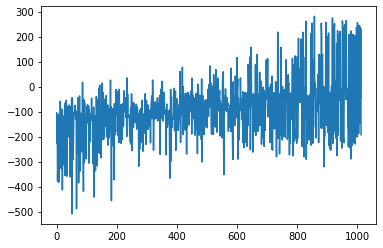

In [125]:
xvals = np.arange(1013)
plt.plot(xvals, reward_history);

In [ ]:
#Run 100 test iterations using the trained model; will store videos in "videotest" folder

testenv = gym.make("LunarLander-v2")
testenv = gym.wrappers.RecordVideo(testenv, 'videotest', episode_trigger = lambda x: x % 1 == 0)

total_rewards = 0
training_steps = 0
i_benchmark = 0
test_history = []

for i in range(100):
    training_rewards = 0
    obs = testenv.reset()
    done = False
    episode_steps = 0
    while not done:
        episode_steps += 1
        observation = obs.reshape([1, obs.shape[0]])
        pred_action = target_model.predict(observation).flatten()
        action = np.argmax(pred_action)
        new_obs, reward, done, _ = testenv.step(action)
        obs = new_obs
        training_rewards += reward
        if done:
            total_rewards += training_rewards
            test_history.append(training_rewards)
            break

env.close()

19.520462951107085 178.93730505751935 289.2638693402678


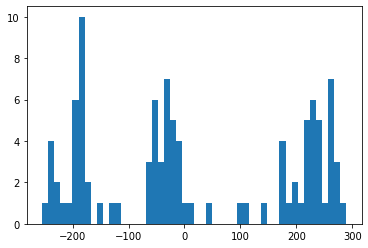

In [128]:
plt.hist(test_history,bins=50);
print(np.mean(test_history), np.std(test_history), max(test_history))

In [ ]:
show_video('videotest', 20)

/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


-199.90630528721664 119.79017334128199 39.32448680971413


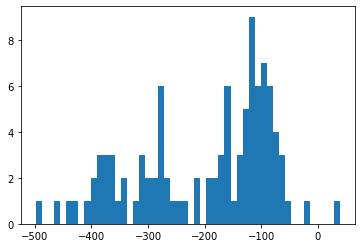

In [131]:
#Run 100 random iterations and plot

randenv = gym.make("LunarLander-v2")

total_rewards = 0
training_steps = 0
i_benchmark = 0
randreward_history = []


for i in range(100):
    training_rewards = 0
    obs = randenv.reset()
    done = False
    episode_steps = 0
    while not done:
        episode_steps += 1
        action = randenv.action_space.sample()
        new_obs, reward, done, _ = randenv.step(action)
        obs = new_obs
        training_rewards += reward

        if done:
            total_rewards += training_rewards
            randreward_history.append(training_rewards)
            break

plt.hist(randreward_history,bins=50);
print(np.mean(randreward_history), np.std(randreward_history), max(randreward_history))

**Conclusions**

The DQL agent is certainly not perfect. Performance continued to trend upwards after 1000 episodes. I suspect with more training, it would truly become proficient. An inspection of the videos after training reveals that the agent has been incentivized to remain above the landing pad without descending, only attempting to land once it has been destabilized. For future work, I would look at the reward structure to see if I could add a small reward for descending or a small penalty for delay.

Though results weren’t spectacular, I propose that this is a product mostly of the lack of training time available for this project. I would like to extend the work to compare with other types of reinforcement learning agents. I think a hand-crafted environment-parser could successfully translate the state of the environment into a simple enough format to allow for traditional q-learning. Alternately, another approach would be to use a neural network to characterize the state into one of a limited number of categories, then perform q-learning based on that. This would be more flexible and less prone to human error.

I would also like to have been able to compare to a reflex agent that could provide a better benchmark than the random agent. This could be done by categorizing the provided state variables (e.g., “close to landing pad on left side” vs. “far from landing pad on left side.”) Since the lander’s angle affects the effects of each engine, this would be quite complicated, but rewarding. It would certainly show that a RL algorithm is a much more efficient solution.

Additionally, the lunar lander has the advantage of provided a pre-parsed description of the environment state into a simple set of eight variables. Other environments, such as the Atari games, provide only the visual representation of the screen. To create a RL agent for that would require a neural network to even begin describing the state.

**Video**

Video: 

https://youtu.be/oUk6aE1dNMo



**References:**

https://www.gymlibrary.ml/environments/box2d/lunar_lander/
Description of Lunar Lander environment

https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb#scrollTo=XDKGJ9A3O8fT
This Colab Notebook provided me with the means to get the Atari environments up and running and output videos successfully. I had spent three days fruitlessly trying to begin the project before I found this, so I much appreciate it. I ended up going with the box2d environment but I did retain the methods for displaying video (updated for flexibility and new methods in the latest version of gym.)

https://medium.com/@ashish_fagna/understanding-openai-gym-25c79c06eccb
This article was useful to understand the basics of gym.

https://towardsdatascience.com/reinforcement-learning-with-openai-d445c2c687d2
This article was useful when I sketched out a Q-Learning approach, before realizing that a DQL approach was necessary.

https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
This was crucial in understanding deep q learning. I did lean very heavily on the cartpole example when crafting my algorithm for the Lunar Lander.
